# Некоторые приложения выпуклой оптимизации
(основано на примерах к CVXPY, [ссылка](https://www.cvxpy.org/examples/index.html))

In [1]:
import numpy as np
import cvxpy as cvx
print(cvx.installed_solvers())
import matplotlib.pyplot as plt

['ECOS', 'ECOS_BB', 'CVXOPT', 'GLPK', 'GLPK_MI', 'SCS', 'MOSEK', 'OSQP']


In [ ]:
USE_COLAB = False
if USE_COLAB:
    !wget -q https://github.com/amkatrutsa/MIPT-Opt/blob/master/01-Intro/kandinskiy_comp_viii.jpg?raw=true -O kandinskiy_comp_viii.jpg
    !wget -q https://github.com/amkatrutsa/MIPT-Opt/blob/master/01-Intro/lena_small.jpg?raw=true -O lena_small.jpg
    !wget -q https://github.com/amkatrutsa/MIPT-Opt/blob/master/01-Intro/test_sound.wav?raw=true -O test_sound.wav
else:
    plt.rc("text", usetex=True)

<img src="./cvxpy_solvers.png" width=1000>

## Удаление шума

- Изображение
- Звук

### Изображение

In [6]:
from PIL import Image

# np.random.seed(1)
# Load image
orig_img = Image.open("./kandinskiy_comp_viii.jpg")
# orig_img = Image.open("./lena_small.jpg")

# Convert to arrays
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape
print(Uorig.shape)

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1

# Create corrupted image
Ucorr = Known * Uorig
# Convert to image
corr_img = Image.fromarray(np.uint8(Ucorr))

(512, 512, 3)


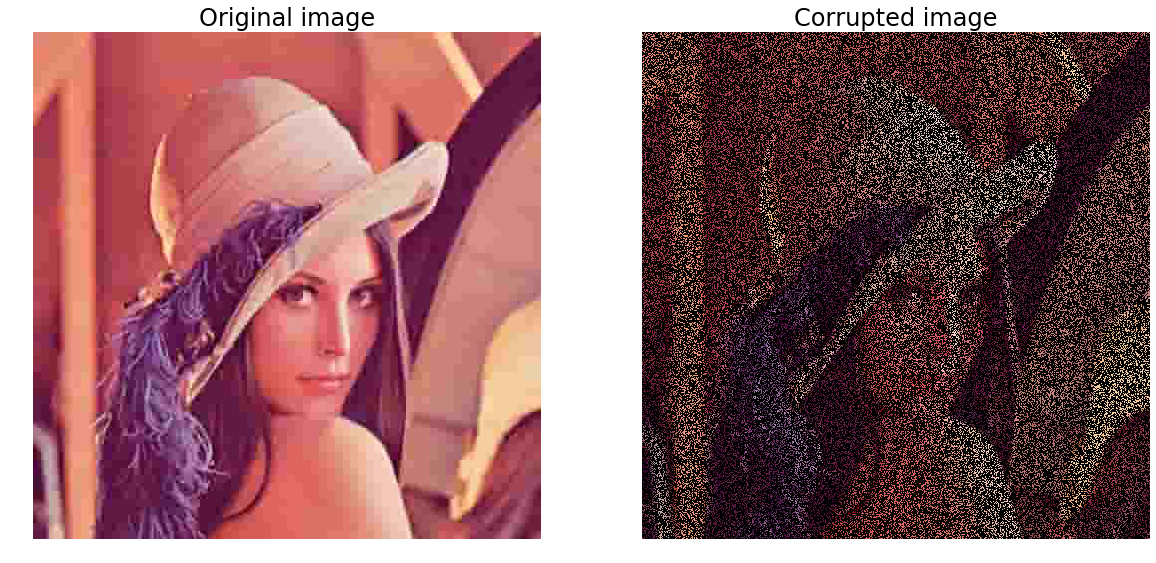

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(orig_img);
ax[0].set_title("Original image", fontsize=24)
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted image", fontsize=24)
ax[1].axis('off');

### Total variation

$$
\begin{align*}
& \min_{X} \sum_{i=1}^{m-1}\sum_{j=1}^{n-1} \left\|\left[ \begin{array}{} 
X_{i+1,j} - X_{ij} \\ X_{i, j+1} - X_{ij}\end{array} \right] \right\|_2\\
\text{s.t. } & X_{ij} = X^{known}_{ij}, \; (i, j) \in \mathcal{I}
\end{align*}
$$

- $\mathcal{I}$ - множество индексов известных значений
- Аппроксимация градиента не в квадрате!

In [4]:
# Define variables and constraints
variables = []
constraints = []
for i in range(colors):
#     Slice of image tensor for the i-th color
    U = cvx.Variable(shape=(rows, cols))
#     Append to the list of variables
    variables.append(U)
#     Append constraints: known pixels in the given image 
#     has to be equal to the pixels in reconstructed image
    constraints.append(cvx.multiply(Known[:, :, i], U) == \
                       cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))

In [6]:
# Create minimization problem with created constraints and solve it
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver="SCS", max_iters=500)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2712552         
  Cones                  : 270936          
  Scalar variables       : 2983488         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
GP based matrix reordering started.
GP based matrix reordering terminated.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2712552         
  Cones                  : 270936          
  Scalar variables       : 2983488         
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            

4605424.08734452

In [7]:
# Load variables values into array
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

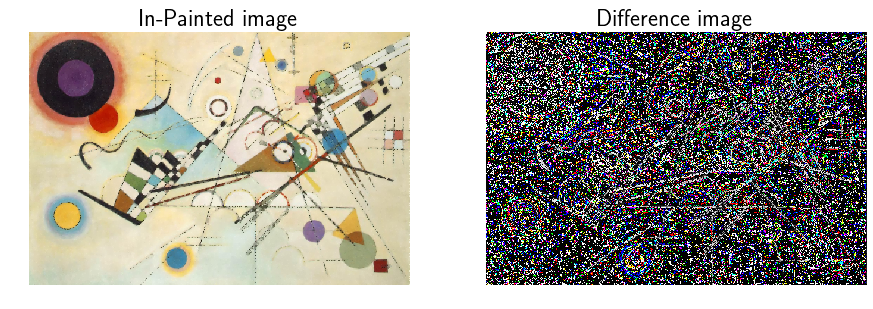

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted image", fontsize=24)
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference image", fontsize=24)
ax[1].axis('off');

### Звук

44100 (7636608,) <class 'numpy.int16'>
Problem dimension = 500000


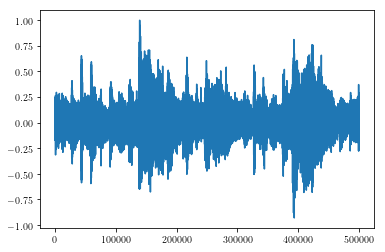

In [10]:
import scipy.io.wavfile as siowav
import IPython.display as ipd

# Load original track
sr, sound = siowav.read("./test_sound.wav")
print(sr, sound.shape, type(sound[0]))
start = 500000
fin = 1000000
sound = sound.astype("float32")
# Cut and normalize original track
sound = sound[start:fin] / np.max(sound[start:fin])
n = sound.shape[0]
print("Problem dimension = {}".format(n))
plt.plot(sound)
# plt.xscale("log")

In [11]:
ipd.Audio(sound, rate=sr)

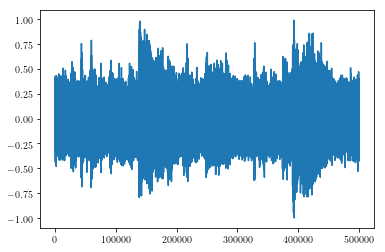

In [12]:
# Create corrupted signal and normalize it 
corrupt_sound = sound + 0.1 * np.random.randn(sound.shape[0])
corrupt_sound = corrupt_sound / np.max(np.abs(corrupt_sound))
plt.plot(corrupt_sound)
# plt.xscale("log")

In [13]:
ipd.Audio(corrupt_sound, rate=sr)

#### $\ell_1$ регуляризация

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} |x_i - x_{i+1}|\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [24]:
# Create variable for reconstructed signal 
x_rec = cvx.Variable(corrupt_sound.shape[0])
# Create ac problem and solve it, \lambda = 1 
prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + cvx.tv(x_rec)),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver=cvx.SCS, max_iters=500)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4499995, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1000000, constraints m = 2499999
Cones:	linear vars: 1999998
	soc vars: 500001, soc blks: 1
Setup time: 2.44e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.29e+22  1.73e+22  1.00e+00 -7.66e+27  1.07e+26  3.65e+27  2.78e+00 
   100| 2.42e-02  3.71e-02  8.94e-02 -3.57e+02 -4.28e+02  1.32e-09  1.08e+02 
   200| 3.19e-03  4.95e-03  1.14e-01  1.28e+02  1

96.66698808735805

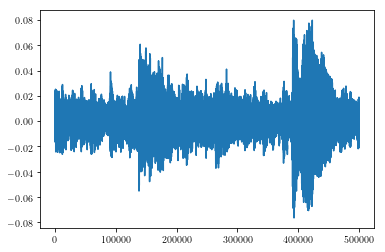

In [25]:
plt.plot(x_rec.value)

In [26]:
ipd.Audio(x_rec.value, rate=sr)

#### $\ell_2$ регуляризация

$$
\begin{align*}
& \min_{x} \|x - x_c\|_2 + \lambda \sum_{i=1}^{n-1} (x_i - x_{i+1})^2\\
\text{s.t. } & -1 \leq x_i \leq 1
\end{align*}
$$

In [27]:
# The same as in the previous cell, but with \ell_2 regularization 
x_rec = cvx.Variable(n)
prob = cvx.Problem(cvx.Minimize(cvx.norm(x_rec - corrupt_sound) + 
                                cvx.square(cvx.norm(x_rec[1:n] - x_rec[0:n-1]))),
                   [x_rec >= -1, x_rec <= 1])
prob.solve(verbose=True, solver="SCS", max_iters=500)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2500003, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 500003, constraints m = 2000004
Cones:	linear vars: 1000000
	soc vars: 1000004, soc blks: 3
Setup time: 1.51e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.60e+22  8.94e+21  1.00e+00 -6.75e+24  4.49e+23  5.02e+24  1.28e+00 
   100| 6.41e-03  5.96e-03  4.71e-04  7.58e+01  7.57e+01  1.67e-13  5.49e+01 
   200| 3.07e-04  2.71e-04  8.68e-04  7.56e+01  7

75.48107902807476

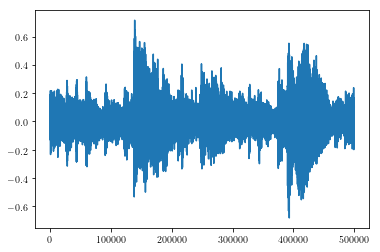

In [28]:
plt.plot(x_rec.value)

In [29]:
ipd.Audio(x_rec.value, rate=sr)

### Выводы

- Различная регуляризация даёт решение с различными свойствами
- Разница между $\ell_1$ и $\ell_2$ регуляризацией
- Способы выбора парамера $\lambda$

## Управление линейной динамической системой

- Дано $x_1, u_1, u_2, \ldots$
- Найти $x_2, x_3, \ldots$ рекурсивно

$$
x_{t+1} = Ax_t + Bu_t
$$

- Пример: движение материальной точки с трением на плоскости

$$
m \frac{v_{t+1} - v_t}{\tau} \approx -\eta v_t + u_t \quad \frac{p_{t+1} - p_t}{\tau} \approx v_{t},
$$
 
где $v_{t} = (v^x_t, v^y_t)$ и $p_t = (p^x_t, p^y_t)$

Приближённо имеем следующую систему

$$
v_{t+1} = \left(1 - \frac{\tau}{m}\eta \right)v_t + \frac{\tau}{m}u_t \quad p_{t+1} = p_t + \tau v_t
$$

Для записи в стандартной форме

$$
x_{t} = \begin{bmatrix} p^x_t \\ p^y_t \\ v^x_t \\ v^y_t \end{bmatrix} \quad A = \begin{bmatrix} 1 & 0 & \tau & 0 \\ 0 & 1 & 0 & \tau \\ 0 & 0 & 1 - \frac{\tau}{m}\eta & 0\\ 0 & 0 & 0 & 1 - \frac{\tau}{m}\eta  \end{bmatrix} \quad B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \frac{\tau}{m} & 0 \\ 0 & \frac{\tau}{m} \end{bmatrix}
$$

### Управление

- Дано начальное состояние системы $x_1$
- Найти такие $u_1, \ldots, u_T$, чтобы была достигнута некоторая цель
    - было достигнуто заданное финальное состояние $x_{target}$
    - было затрачено минимум "энергии"

In [19]:
m = 1
eta = 0.1
tau = 0.01
T = 100
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta * tau / m, 0], 
              [0, 0, 0, 1 - eta * tau / m]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m, 0],
             [0, tau / m]])

In [20]:
# Initialize original and target states of the defined system
x0 = np.array([5, 5, 20, -5])
x_target = np.array([0, 7, 0, 0])

In [21]:
# Create variables to store evolution of the system and 
# all control vectors
x = cvx.Variable((4, T + 1))
u = cvx.Variable((2, T))

states = []
for t in range(T):
#     Create objective function and constraints in every time step
    cost = cvx.sum_squares(u[:, t])
    constr = [x[:, t+1] == A*x[:, t] + B*u[:, t]]
    states.append(cvx.Problem(cvx.Minimize(cost), constr))
# Sum-up all problems: sum objectives and concatenate constraints 
prob0 = sum(states)
# Append original state and target state
complete_constr = prob0.constraints + [x[:,0] == x0, x[:, T] == x_target]
prob = cvx.Problem(prob0.objective, complete_constr)
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 804, constraints m = 608
          nnz(P) + nnz(A) = 1808
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.00e+01   2.00e+03   1.00e-01   1.11e-03s
  75   3.3624e+05   2.52e-06   9.20e-10   9.18e+01   1.36e-03s

status:               solved
solution polish:      unsuccessf

336238.1650251802

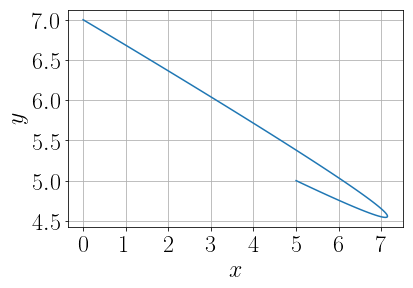

In [22]:
plt.plot(x.value[0, :], x.value[1, :])
plt.grid(True)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r"$x$", fontsize=24)
plt.ylabel(r"$y$", fontsize=24)

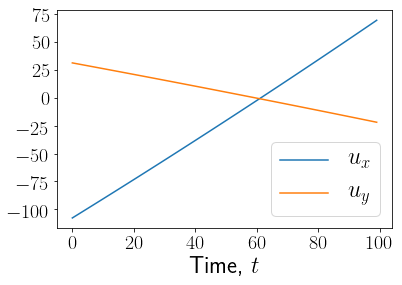

In [23]:
plt.plot(u.value[0, :], label=r"$u_x$")
plt.plot(u.value[1, :], label=r"$u_y$")
plt.legend(fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Time, $t$", fontsize=24)

### Задача rendezvous

- Дано два тела, каждый со своей динамикой, то есть матрицами $A$ и $B$, начальными положениями и скоростями
- Найти $u_i$ и $v_i$ для каждого тела, так чтобы их конечные состояния были одинаковыми и была потрачено суммарно минимум энергии

#### Формальная постановка

$$
\begin{align*}
& \min \sum_{i=1}^T \|u_i\|_2^2 + \|v_i\|_2^2 \\
\text{s.t. } & x_{t+1} = Ax_t + Bu_t, \; t = 1,\ldots,T-1\\
& z_{t+1} = Cz_t + Dv_t, \; t = 1,\ldots,T-1\\
& x_T = z_T
\end{align*}
$$

In [24]:
m1 = 1
eta1 = 0.1
m2 = 1
eta2 = 1
tau = 0.01
T = 100
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta1 * tau / m1, 0], 
              [0, 0, 0, 1 - eta1 * tau / m1]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m1, 0],
             [0, tau / m1]])

C = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta2 * tau / m2, 0], 
              [0, 0, 0, 1 - eta2 * tau / m2]])
D = np.array([[0, 0],
             [0, 0],
             [tau / m2, 0],
             [0, tau / m2]])

In [25]:
x0 = np.array([0, 0, 1, 1])
z0 = np.array([10, 0, -1, 1])

In [26]:
x = cvx.Variable((4, T + 1))
z = cvx.Variable((4, T + 1))
u = cvx.Variable((2, T))
v = cvx.Variable((2, T))

states = []
for t in range(T):
    cost = cvx.sum_squares(u[:, t]) + cvx.sum_squares(v[:, t])
    constr = [x[:, t+1] == A*x[:, t] + B*u[:, t], z[:, t+1] == C*z[:, t] + D*v[:, t]]
    states.append(cvx.Problem(cvx.Minimize(cost), constr))
prob0 = sum(states)
complete_constr = prob0.constraints + [x[:, T] == z[:, T], x[:, 0] == x0, z[:, 0] == z0]
prob = cvx.Problem(prob0.objective, complete_constr)
prob.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 1608, constraints m = 1212
          nnz(P) + nnz(A) = 3616
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+01   1.00e+03   1.00e-01   4.52e-03s
  75   5.0981e+04   1.25e-05   3.33e-09   5.79e+01   5.17e-03s

status:               solved
solution polish:      unsucces

50981.25938336443

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

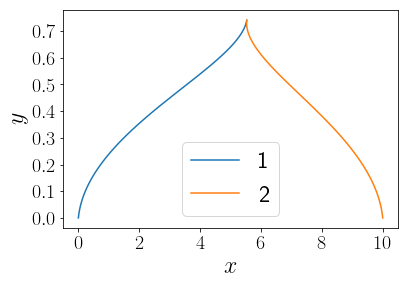

In [27]:
plt.plot(x.value[0, :], x.value[1, :], label="1")
plt.plot(z.value[0, :], z.value[1, :], label="2")
plt.legend(fontsize=24)
plt.xlabel(r"$x$", fontsize=24)
plt.ylabel(r"$y$", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

### История и современное состояние

- Подобные задачи начали решать для планирования полётов спутников и космических кораблей
- В СССР была сильная школа оптимального управления, см принцип максимума Понтрягина и другие работы
- Сейчас SpaceX использует [CVXGEN](https://cvxgen.com/docs/index.html) для точной посадки своих ракет, [ссылка](https://www.nae.edu/19582/Bridge/164237/164334.aspx) 
- CVXGEN позволяет генерировать и очень быстро решать задачи квадратичного программирования небольшого размера, подробнее [тут](http://stanford.edu/~boyd/papers/code_gen_rhc.html)
- Это достигается за счёт автоматической генерации кода для решения задачи и его компиляции под конкретную систему

## Экстремальный эллипсоид (The L&ouml;wner-John ellipsoid)

**Задача**: дан набор точек на плоскости $x_i \in \mathbb{R}^2$, необходимо найти эллипс минимальной площади, такой что все точки $x_i$ лежат внутри него. 

**Приложения**

- Телекоммуникации
- Оценка ковариационной матрицы

**Параметры**: 

эллипс можно задать аффинным преобразованием

$$
\{x \; | \; \| x \|^2_2 \leq 1\} \to \{ u \;| \; \|u\|^2_2 \leq 1, \; u = Ax + b\}
$$

Тогда площадь увеличивается в $\det (A^{-1})$ раз. 

- Детерминант не является выпуклой/вогнутой функцией
- $\log\det(A^{-1}) = -\log\det(A)$ - выпуклая функция при $A \in \mathbb{S}^n_{++}$

### Задача минимизации

$$
\begin{align*}
& \min_{A, b} -\log\det(A)\\
\text{s.t. } & \|Ax_i + b\| \leq 1\\
& A \succ 0
\end{align*}
$$

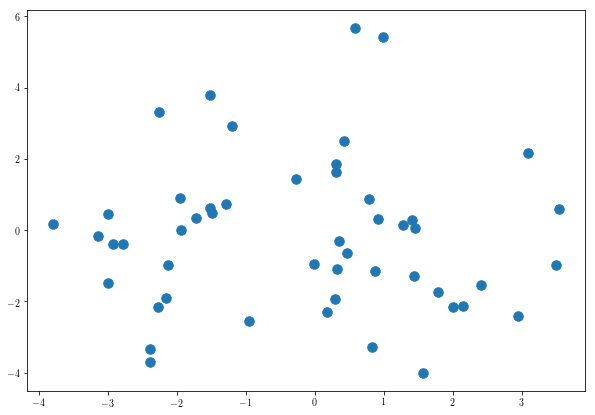

In [2]:
num_points = 50
n = 2
X = 2 * np.random.randn(n, num_points)
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :], s=90)

In [3]:
# Create variables: positive semi-definite matrix A and vector b
A = cvx.Variable((n,n), PSD=True)
b = cvx.Variable((n,))
prob = cvx.Problem(cvx.Minimize(-cvx.log_det(A)), 
   [cvx.norm(A * X[:, i] + b) <= 1 for i in range(num_points)])

In [4]:
prob.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 447, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 73, constraints m = 237
Cones:	primal zero / dual free vars: 15
	linear vars: 50
	soc vars: 150, soc blks: 50
	sd vars: 16, sd blks: 3
	exp vars: 6, dual exp vars: 0
Setup time: 1.37e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.02e+00  1.74e+00  9.19e-01 -8.59e+00  2.75e+00  5.83e-15  8.31e-02 
   100| 1.54e-02  1.81e-03  3.27e-03  2.80e+00  2.82e+00  1.00e-15  9.09e-02 
   200| 6.28e-03  1.17e

2.966477750359045

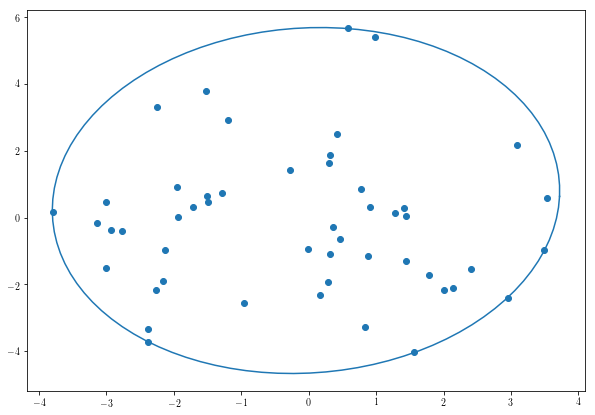

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi) - b.value[0], np.sin(phi) - b.value[1]))
ellips = np.linalg.solve(A.value, xy)
plt.plot(ellips[0, :], ellips[1, :])

## Метод опорных векторов (SVM)

- Дана выборка $(X, y)$, где $X \in \mathbb{R}^{m \times n}$ и $y_i \in \{ +1, -1\}$
- Необходимо построить линейный классификатор вида $\hat{y}_i = \mathrm{sgn}(w^{\top}x_i + b)$, где $w \in \mathbb{R}^n$ и $b \in \mathbb{R}$
- Параметры $w$ и $b$ найдём с помощью следующей задачи оптимизации

$$
\min_{w, b} \frac{1}{m} \sum_{i=1}^m \max(0, 1 - y_i(w^{\top}x_i + b)) + \gamma \|w\|_{*}
$$

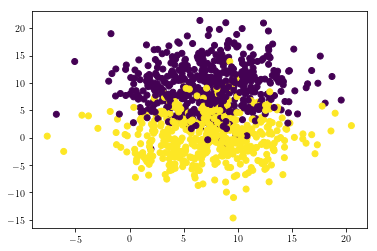

In [61]:
import sklearn.datasets as skldata
import sklearn.model_selection as skms

np.random.seed(8)
n = 2
m = 2000
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4)
y = 2 * y - 1
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
m_train = m // 2
m_test = m_train

In [62]:
beta = cvx.Variable(n)
v = cvx.Variable()
loss = cvx.sum(cvx.pos(1 - cvx.multiply(y_train, X_train*beta + v)))
reg = cvx.norm(beta, 2)
lambd = cvx.Parameter(nonneg=True, value=1)
prob = cvx.Problem(cvx.Minimize(loss / m_train + lambd * reg))
prob.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +9.464e-02  +4.993e+02  +4e+03  8e-01  9e+00  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  +5.030e+02  +1.474e+04  +1e+03  2e+01  8e+02  2e+02  5e-01  0.7543  5e-02   1  1  1 |  0  0
 2  +2.581e+02  +5.319e+03  +8e+02  6e+00  4e+02  8e-01  4e-01  0.2965  4e-02   1  1  1 |  0  0
 3  +1.618e+01  +5.792e+02  +5e+02  6e-01  6e+01  3e+01  2e-01  0.5494  3e-01   1  1  1 |  0  0
 4  +1.339e+01  +1.409e+02  +2e+02  1e-01  3e+01  2e-01  9e-02  0.6793  7e-02   2  1  1 |  0  0
 5  +3.379e+00  +2.125e+01  +1e+02  2e-02  3e+00  4e-01  6e-02  0.5781  5e-01   1  1  1 |  0  0
 6  +1.385e+00  +3.447e+00  +3e+01  2e-03  2e-01  1e-02  2e-02  0.7952  9e-02   1  1  1 |  0  0
 7  +8.774e-01  +1.759e+00  +3e+01  7e-04  6e-02  8e-03  1e-02  0.4331  5e-01   1  1  1 |  0  0
 8  +6.065e-01  +7.095e-01  +6e+00  6e-05  4e-

0.5676182480511398

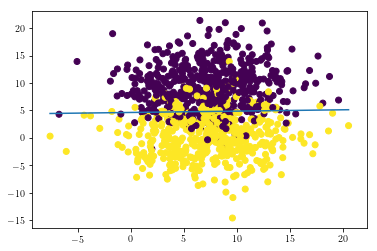

In [63]:
x = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]))
plt.plot(x, (-v.value - beta.value[0] * x) / beta.value[1])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Зависимость от $\lambda$

In [42]:
import sklearn.datasets as skdata 
import sklearn.preprocessing as skprep

X, y = skdata.load_breast_cancer(return_X_y=True)
X = skprep.StandardScaler().fit_transform(X)

y = 2 * y - 1
print("Data shape = {}".format(X.shape))
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.3)
m_train, n = X_train.shape
m_test = X_test.shape[0]
# Redefine the problem
beta = cvx.Variable(n)
v = cvx.Variable()
loss = cvx.sum(cvx.pos(1 - cvx.multiply(y_train, X_train*beta + v)))
reg = cvx.norm(beta, 1)
lambd = cvx.Parameter(nonneg=True)
prob = cvx.Problem(cvx.Minimize(loss / m_train + lambd * reg))

Data shape = (569, 30)


In [52]:
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-4, -1, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(solver="ECOS")
    train_error[i] = (y_train != np.sign(X_train.dot(beta.value) + v.value)).sum() * 1.0 / m_train
    test_error[i] = (y_test != np.sign(X_test.dot(beta.value) + v.value)).sum() * 1.0 / m_test
    beta_vals.append(beta.value)

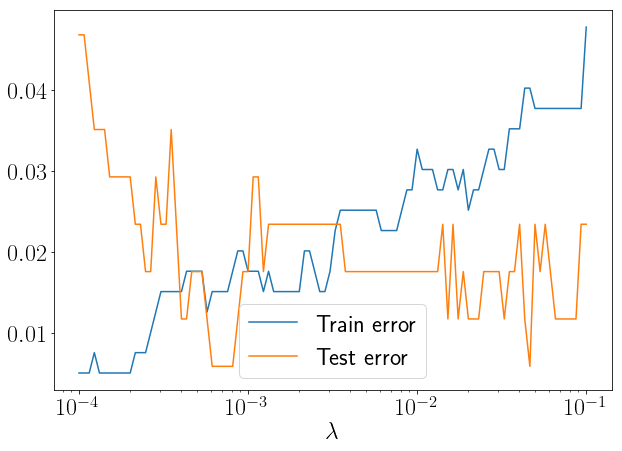

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='best', fontsize=24)
plt.xlabel(r"$\lambda$", fontsize=24)
plt.xticks(fontsize=24)
_ = plt.yticks(fontsize=24)

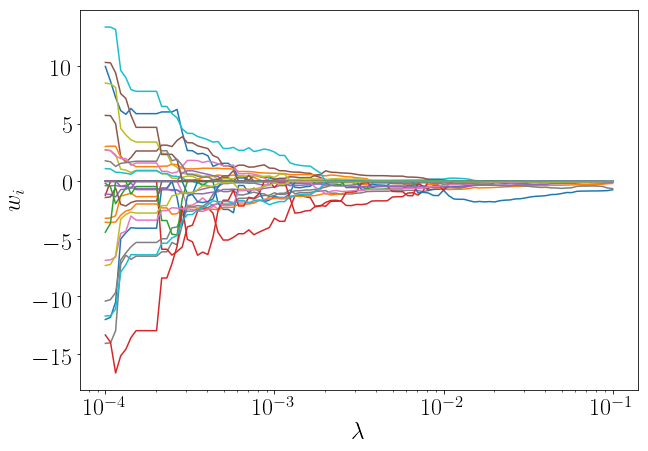

In [54]:
plt.figure(figsize=(10, 7))
for i in range(n):
    plt.plot(lambda_vals, [wi[i] for wi in beta_vals])
plt.xlabel(r"$\lambda$", fontsize=24)
plt.ylabel(r"$w_i$", fontsize=24)
plt.xscale("log")
plt.xticks(fontsize=24)
_ = plt.yticks(fontsize=24)

## Что осталось за кадром

- Портфельная теория Марковица
- Поиск равновесия в транспортных сетях
- Регрессия
- Задачи из биологии
- Релаксации комбинаторных задач
- Распределение энергии в сетях
- Составление расписания потребления мощности
- Задачи из статистики
- Инженерные задачи про формирование массива антенн, про распределение нагрузок в механической конструкции, etc